In [1]:
import csv
import math
import pickle
import datetime as dt
import pandas as pd
import pandas_profiling
import numpy as np
import warnings
import sklearn

from scipy import stats
from dateutil.parser import parse
from datetime import datetime
from IPython.display import display_html
from sklearn.linear_model import LinearRegression
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from yellowbrick.regressor import ResidualsPlot
from sklearn import linear_model
from pprint import pprint

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

/opt/conda/anaconda/lib/python3.7/site-packages/dask/dataframe/utils.py:14: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/opt/conda/anaconda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button style="color:"black";right:75%;" onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [3]:
######################################################################## ALL USER DEFINED FUNCTION ARE LOGGED HERE #############################################################################
################################################################################################################################################################################################

# calculate rmse scores
def rmse(pred_test, y_test):
    return np.sqrt(((pred_test - y_test) ** 2).mean())

# calculate mape scores
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# get names of all categorical data present in data
def get_index_of_categorical_columns(df):
    cols = df.columns
    num_cols = df._get_numeric_data().columns
    return list(set(cols) - set(num_cols))


def do_union(lst1, lst2, lst3, lst4): 
    final_list = list(set(lst1) | set(lst2) | set(lst3) | set(lst4))
    return final_list 

In [44]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################
####### Load ADS using name and path


load_ads = pd.read_csv('gs://aes-datahub-0002-curated/Outage_Restoration/Historical_Data/Master_Dataset/OMS_IPL_OUTAGE_V10.4_IQR_09152020.csv')
print('\n')
display(load_ads.head())
print('\n')
print('\n')
print(list(load_ads.columns))

,EVENT,CREATION_DATETIME,DNI_EQUIP_TYPE,CALL_QTY,DOWNSTREAM_CUST_QTY,KEY_CUST_QTY,DAY_FLAG,TTR,POLE_CLUE_FLG,PART_LIGHT_CLUE_FLG,EMERGENCY_CLUE_FLG,POWER_OUT_CLUE_FLG,OPEN_DEVICE_CLUE_FLG,TREE_CLUE_FLG,WIRE_DOWN_CLUE_FLG,IVR_CLUE_FLG,EQUIPMENT_CLUE_FLG,TRANSFORMER_CLUE_FLG,OH_CAUSE_FLG,UG_CAUSE_FLG,ANIMAL_CAUSE_FLG,WEATHER_CAUSE_FLG,WEATHER_COLD_CAUSE_FLG,PUBLIC_CAUSE_FLG,WEATHER_LIGHTNING_CAUSE_FLG,WEATHER__SNOW_CAUSE_FLG,WEATHER__WIND_CAUSE_FLG,WEATHER__HEAT_CAUSE_FLG,CUST_REQUEST_CAUSE_FLG,WEATHER__FLOOD_CAUSE_FLG,STREET_CAUSE_FLG,SUBSTATION_CAUSE_FLG,TREE_CAUSE_FLG,MISCELLANEOUS_CAUSE_FLG,NO_CAUSE_FLG,PLANNED_CAUSE_FLG,NO_OUTAGE_CAUSE_FLG,FUSE_OCCURN_FLG,CUST_EQUIP_OCCURN_FLG,POLE_OCCURN_FLG,TRANSFORMER_OCCURN_FLG,METER_OCCURN_FLG,SERVICE_OCCURN_FLG,CABLE_OCCURN_FLG,ST_OCCURN_FLG,FIRE_OCCURN_FLG,FOUND_OPEN_OCCURN_FLG,PUBLIC_SAFETY_OCCURN_FLG,WIRE_OCCURN_FLG,SWITCH_OCCURN_FLG,REGULATOR_OCCURN_FLG,CUTOUT_OCCURN_FLG,CAP_BANK_OCCURN_FLG,RECLOSER_OCCURN_FLG,OH_OCCURN_FLG,PRIORITY_VAL_1.0,PRIORITY_VAL_2.0,PRIORITY_VAL_3.0,PRIORITY_VAL_5.0,CITY_NAM,ZONE,NO_OF_POWER_OUT_CLUE_PER_DAY,NO_OF_OPEN_DEVICE_CLUE_PER_DAY,NO_OF_IVR_CLUE_PER_DAY,NO_OF_ANIMAL_CAUSE_PER_DAY,NO_OF_WIRE_OCCURN_PER_DAY,Hour_Sin,Hour_Cos,RANK_SUBSEQUENT_OUTAGES,Outages_in_last_1hr,Outages_in_last_2hr,Outages_in_last_3hr,Outages_in_last_4hr,Outages_in_last_5hr,Outages_in_last_6hr,Outages_in_last_7hr,Outages_in_last_8hr,Outages_in_last_9hr,Outages_in_last_10hr,Weekday,Weekend_flag,Priority_Customer_Qty,Priority_Dist_Customer_Qty,Dispatch_Location,cldCvrAvg,cldCvrMax,cldCvrMin,dewPtAvg,dewPtMax,dewPtMin,feelsLikeAvg,feelsLikeMax,feelsLikeMin,heatIndexAvg,heatIndexMax,heatIndexMin,mslPresAvg,mslPresMax,mslPresMin,precip,radSolarAvg,radSolarMax,radSolarTot,relHumAvg,relHumMax,relHumMin,sfcPresAvg,sfcPresMax,sfcPresMin,snowfall,spcHumAvg,spcHumMax,spcHumMin,tempAvg,tempMax,tempMin,wetBulbAvg,wetBulbMax,wetBulbMin,windChillAvg,windChillMax,windChillMin,windDir100mAvg,windDir80mAvg,windDirAvg,windSpd100mAvg,windSpd100mMax,windSpd100mMin,windSpd80mAvg,windSpd80mMax,windSpd80mMin,windSpdAvg,windSpdMax,windSpdMin,tempRange,windSpdRange,sfcPresRange,cldCvrRange,relHumRange,relHumRatio,sfcPresRatio,Date
0,BLUE SKY,2007-01-01 03:33:00,SSUB,4,177.0,1.0,False,15.0000,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE3,7,1,5,2,1,0.707107,7.071068e-01,1.0,0,0,0,0,0,0,0,0,0,0,Monday,False,1.0,1.0,ARL.,92.0,100.0,44.0,33.9,39.5,30.0,30.3,36.7,24.3,38.5,43.7,34.5,1016.4,1026.0,1008.9,0.0,28.5,125.4,684.3,83.3,90.3,79.3,986.8,995.8,980.1,0.0,4.2,5.2,3.6,38.5,43.7,34.5,36.6,41.7,32.8,30.3,36.7,24.3,269.0,269.0,267.0,16.8,20.3,8.8,17.0,20.6,8.9,14.4,17.8,6.7,9.2,11.1,15.7,56.0,11.0,1.138714,1.016019,2007-01-01 00:00:00
1,BLUE SKY,2007-01-01 08:16:14,FUSE,1,5.0,0.0,True,108.1667,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,INDIANAPOLIS,ZONE4,7,1,5,2,1,0.866025,-5.000000e-01,2.0,0,0,0,0,1,1,1,1,1,1,Monday,False,2.0,2.0,MILL,93.0,100.0,43.0,33.2,39.1,29.5,29.6,36.3,23.5,37.9,43.2,34.0,1016.9,1026.2,1009.3,0.0,29.0,127.2,695.3,83.0,90.0,79.0,986.8,995.7,980.1,0.0,4.1,5.2,3.5,37.9,43.2,34.0,36.0,41.3,32.2,29.6,36.3,23.5,270.0,271.0,268.0,16.8,20.2,8.7,16.9,20.5,8.8,14.4,17.8,6.7,9.2,11.1,15.6,57.0,11.0,1.139241,1.015917,2007-01-01 00:00:00
2,BLUE SKY,2007-01-01 09:36:18,1TBOH,2,6.0,0.0,True,39.6000,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False





['EVENT', 'CREATION_DATETIME', 'DNI_EQUIP_TYPE', 'CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG', 'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_

In [45]:
################################################################################# USER DEFINED FIELDS ###########################################################################################
#################################################################################################################################################################################################

select_columns_from_ads = ['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'DAY_FLAG', 'TTR', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG',
                           'POWER_OUT_CLUE_FLG', 'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                           'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 'WEATHER_COLD_CAUSE_FLG', 
                           'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 
                           'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG',
                           'NO_CAUSE_FLG', 'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                           'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG', 'FIRE_OCCURN_FLG', 
                           'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 'REGULATOR_OCCURN_FLG', 
                           'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0',
                           'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 'ZONE', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                           'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 
                           'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr',
                           'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Weekday', 'Weekend_flag',
                           'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'Dispatch_Location', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 
                           'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg',
                           'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 
                           'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBulbMax',
                           'wetBulbMin', 'windChillAvg', 'windChillMax', 'windChillMin', 'windDir100mAvg', 'windDir80mAvg', 'windDirAvg', 'windSpd100mAvg',
                           'windSpd100mMax', 'windSpd100mMin', 'windSpd80mAvg', 'windSpd80mMax', 'windSpd80mMin', 'windSpdAvg', 'windSpdMax', 'windSpdMin', 
                           'tempRange', 'windSpdRange', 'sfcPresRange', 'cldCvrRange', 'relHumRange', 'relHumRatio', 'sfcPresRatio', 'EVENT']

ads = load_ads[select_columns_from_ads]

ads = pd.get_dummies(ads, columns=['DAY_FLAG', 'POLE_CLUE_FLG', 'PART_LIGHT_CLUE_FLG', 'EMERGENCY_CLUE_FLG', 'POWER_OUT_CLUE_FLG', 
                                   'OPEN_DEVICE_CLUE_FLG', 'TREE_CLUE_FLG', 'WIRE_DOWN_CLUE_FLG', 'IVR_CLUE_FLG', 'EQUIPMENT_CLUE_FLG',
                                   'TRANSFORMER_CLUE_FLG', 'OH_CAUSE_FLG', 'UG_CAUSE_FLG', 'ANIMAL_CAUSE_FLG', 'WEATHER_CAUSE_FLG', 
                                   'WEATHER_COLD_CAUSE_FLG', 'PUBLIC_CAUSE_FLG', 'WEATHER_LIGHTNING_CAUSE_FLG', 'WEATHER__SNOW_CAUSE_FLG', 
                                   'WEATHER__WIND_CAUSE_FLG', 'WEATHER__HEAT_CAUSE_FLG', 'CUST_REQUEST_CAUSE_FLG', 'WEATHER__FLOOD_CAUSE_FLG', 
                                   'STREET_CAUSE_FLG', 'SUBSTATION_CAUSE_FLG', 'TREE_CAUSE_FLG', 'MISCELLANEOUS_CAUSE_FLG', 'NO_CAUSE_FLG', 
                                   'PLANNED_CAUSE_FLG', 'NO_OUTAGE_CAUSE_FLG', 'FUSE_OCCURN_FLG', 'CUST_EQUIP_OCCURN_FLG', 'POLE_OCCURN_FLG', 
                                   'TRANSFORMER_OCCURN_FLG', 'METER_OCCURN_FLG', 'SERVICE_OCCURN_FLG', 'CABLE_OCCURN_FLG', 'ST_OCCURN_FLG',
                                   'FIRE_OCCURN_FLG', 'FOUND_OPEN_OCCURN_FLG', 'PUBLIC_SAFETY_OCCURN_FLG', 'WIRE_OCCURN_FLG', 'SWITCH_OCCURN_FLG', 
                                   'REGULATOR_OCCURN_FLG', 'CUTOUT_OCCURN_FLG', 'CAP_BANK_OCCURN_FLG', 'RECLOSER_OCCURN_FLG', 'OH_OCCURN_FLG', 
                                   'PRIORITY_VAL_1.0', 'PRIORITY_VAL_2.0', 'PRIORITY_VAL_3.0', 'PRIORITY_VAL_5.0', 'CITY_NAM', 
                                   'ZONE', 'Weekday', 'Weekend_flag', 'Dispatch_Location'])

In [46]:
# print list of columns present in the ads and drop na's from the dataset
print(list(ads.columns))
ads.dropna(inplace=True)
print(ads.shape)

['CALL_QTY', 'DOWNSTREAM_CUST_QTY', 'KEY_CUST_QTY', 'TTR', 'NO_OF_POWER_OUT_CLUE_PER_DAY', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY', 'NO_OF_IVR_CLUE_PER_DAY', 'NO_OF_ANIMAL_CAUSE_PER_DAY', 'NO_OF_WIRE_OCCURN_PER_DAY', 'Hour_Sin', 'Hour_Cos', 'RANK_SUBSEQUENT_OUTAGES', 'Outages_in_last_1hr', 'Outages_in_last_2hr', 'Outages_in_last_3hr', 'Outages_in_last_4hr', 'Outages_in_last_5hr', 'Outages_in_last_6hr', 'Outages_in_last_7hr', 'Outages_in_last_8hr', 'Outages_in_last_9hr', 'Outages_in_last_10hr', 'Priority_Customer_Qty', 'Priority_Dist_Customer_Qty', 'cldCvrAvg', 'cldCvrMax', 'cldCvrMin', 'dewPtAvg', 'dewPtMax', 'dewPtMin', 'feelsLikeAvg', 'feelsLikeMax', 'feelsLikeMin', 'heatIndexAvg', 'heatIndexMax', 'heatIndexMin', 'mslPresAvg', 'mslPresMax', 'mslPresMin', 'precip', 'radSolarAvg', 'radSolarMax', 'radSolarTot', 'relHumAvg', 'relHumMax', 'relHumMin', 'sfcPresAvg', 'sfcPresMax', 'sfcPresMin', 'snowfall', 'spcHumAvg', 'spcHumMax', 'spcHumMin', 'tempAvg', 'tempMax', 'tempMin', 'wetBulbAvg', 'wetBu

#### **Load Model Object Using Pickle File**

In [47]:
import gcsfs

fs = gcsfs.GCSFileSystem(project='aes-datahub-0002')
fs.ls('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles')
with fs.open('aes-datahub-0002-curated/Outage_Restoration/Historical_Data/PickleFiles/Random_Forest_GridSearch.pkl', 'rb') as f:
    rf_model = pickle.load(f)

In [48]:
final_features = ['POLE_CLUE_FLG_False', 'tempRange', 'Outages_in_last_9hr', 'NO_OF_WIRE_OCCURN_PER_DAY', 'windDir100mAvg', 'POWER_OUT_CLUE_FLG_True', 'DAY_FLAG_True',
                  'NO_OF_POWER_OUT_CLUE_PER_DAY', 'POWER_OUT_CLUE_FLG_False', 'relHumAvg', 'ST_OCCURN_FLG_True', 'Hour_Cos', 'ST_OCCURN_FLG_False', 'Priority_Customer_Qty',
                  'ANIMAL_CAUSE_FLG_False', 'DOWNSTREAM_CUST_QTY', 'CITY_NAM_NO_CITY', 'NO_CAUSE_FLG_False', 'windSpd80mMax', 'CALL_QTY', 'Priority_Dist_Customer_Qty',
                  'TREE_CAUSE_FLG_True', 'FUSE_OCCURN_FLG_False', 'Outages_in_last_2hr', 'PUBLIC_SAFETY_OCCURN_FLG_True', 'NO_OF_OPEN_DEVICE_CLUE_PER_DAY',
                  'TREE_CAUSE_FLG_False', 'WIRE_OCCURN_FLG_False', 'Outages_in_last_10hr', 'cldCvrRange', 'radSolarTot', 'heatIndexMax', 'ANIMAL_CAUSE_FLG_True',
                  'Outages_in_last_1hr', 'UG_CAUSE_FLG_False', 'PUBLIC_SAFETY_OCCURN_FLG_False', 'NO_OF_IVR_CLUE_PER_DAY']

In [49]:
X = ads[final_features]
y = ads['TTR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('\n')
print('\n')
print(len(X_train),len(X_test))
print(len(y_train),len(y_test))
print('\n')
print('\n')





65883 16471
65883 16471






In [50]:
TTR_pred = rf_model.predict(X)

In [51]:
TTR_pred = list(np.exp(TTR_pred))

In [52]:
ads['TTR_PREDICTED'] = TTR_pred

Text(0.5, 1.0, 'Actual vs Fitted ')

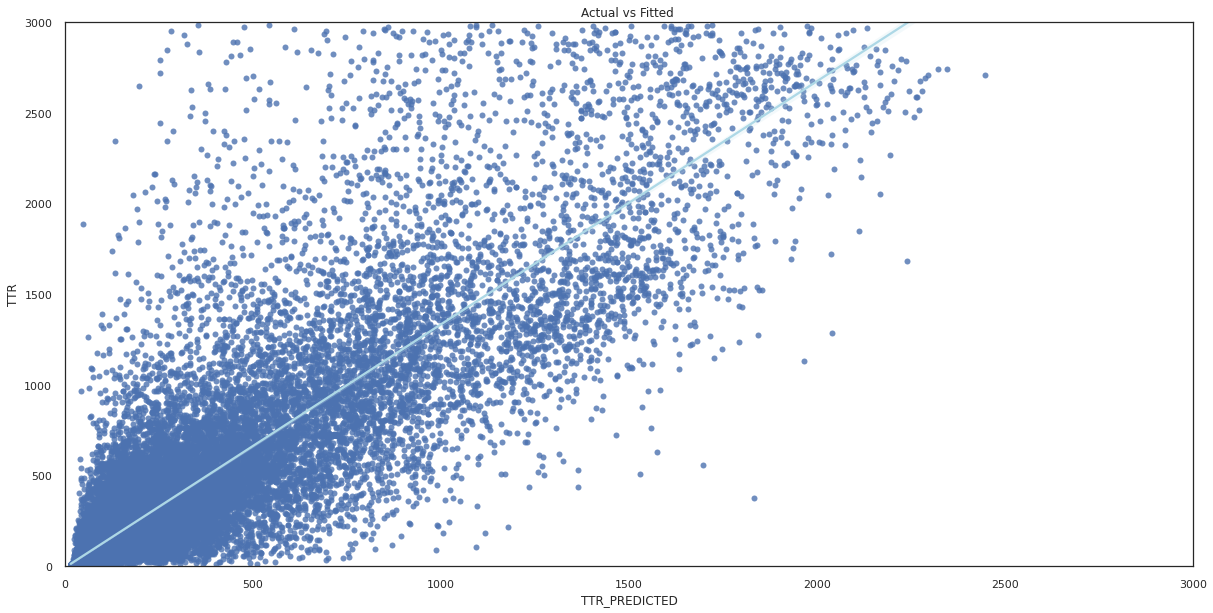

In [57]:
sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
ax = sns.regplot(x="TTR_PREDICTED", y="TTR", data=ads, line_kws={"color": "lightblue"})
ax.set_xlim(0,3000)
ax.set_ylim(0,3000)
ax.set_title('Actual vs Fitted ')

<AxesSubplot:xlabel='TTR_PREDICTED', ylabel='TTR'>

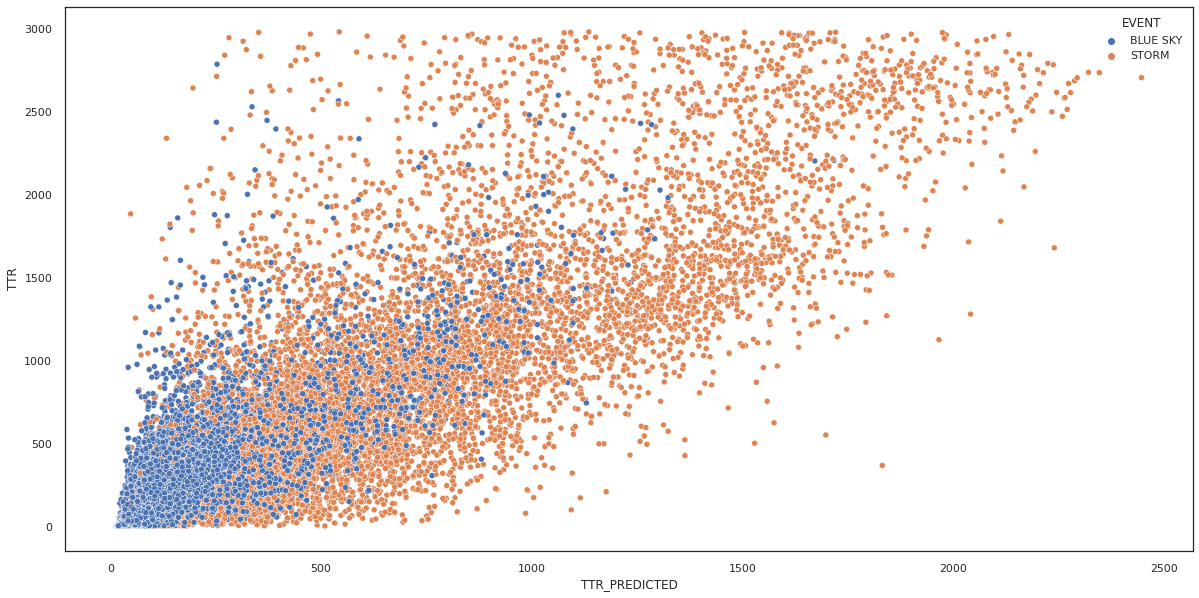

In [58]:
sns.scatterplot(data=ads, x="TTR_PREDICTED", y="TTR", hue="EVENT")

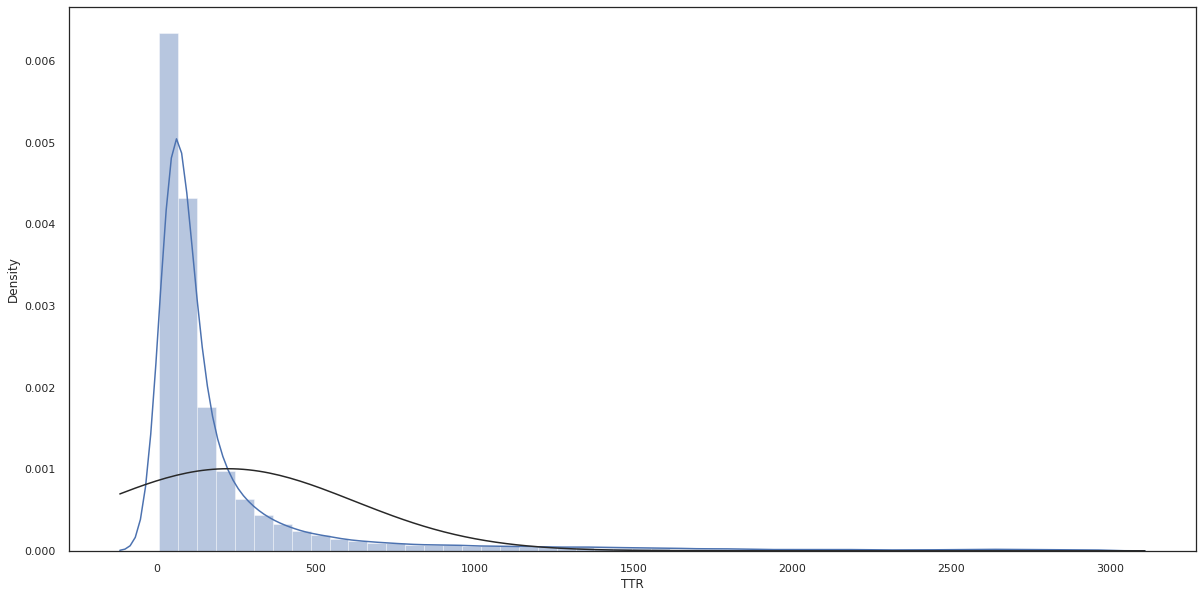

<Figure size 1296x720 with 0 Axes>

In [63]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(18,10)})
sns.set_style("white")
sns.distplot(ads['TTR'],fit=norm);
fig = plt.figure()

In [64]:
ads['TTR_ERROR'] = ads['TTR'] - ads['TTR_PREDICTED']

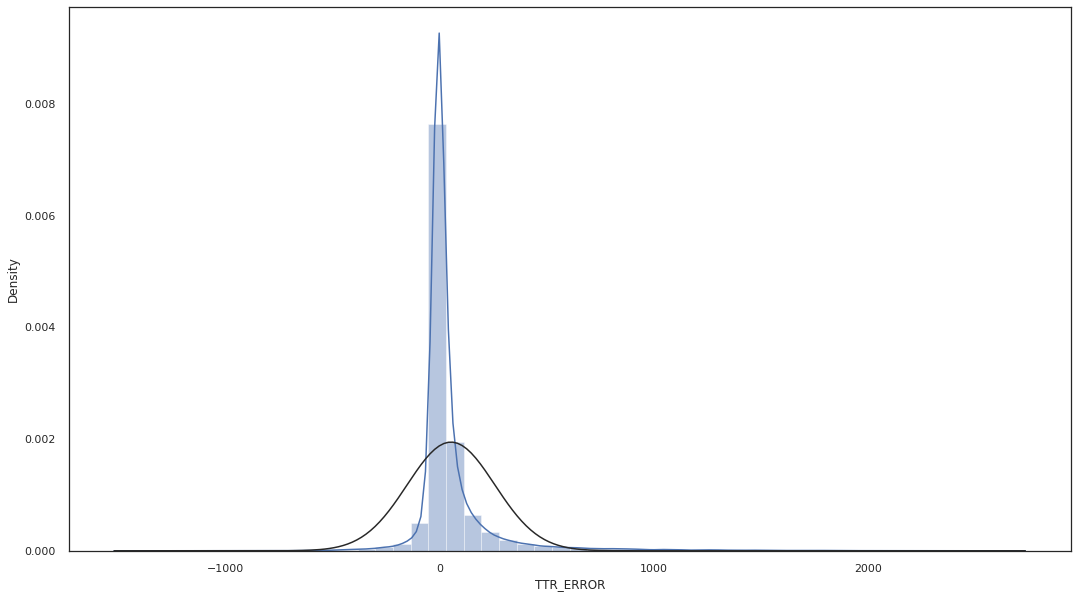

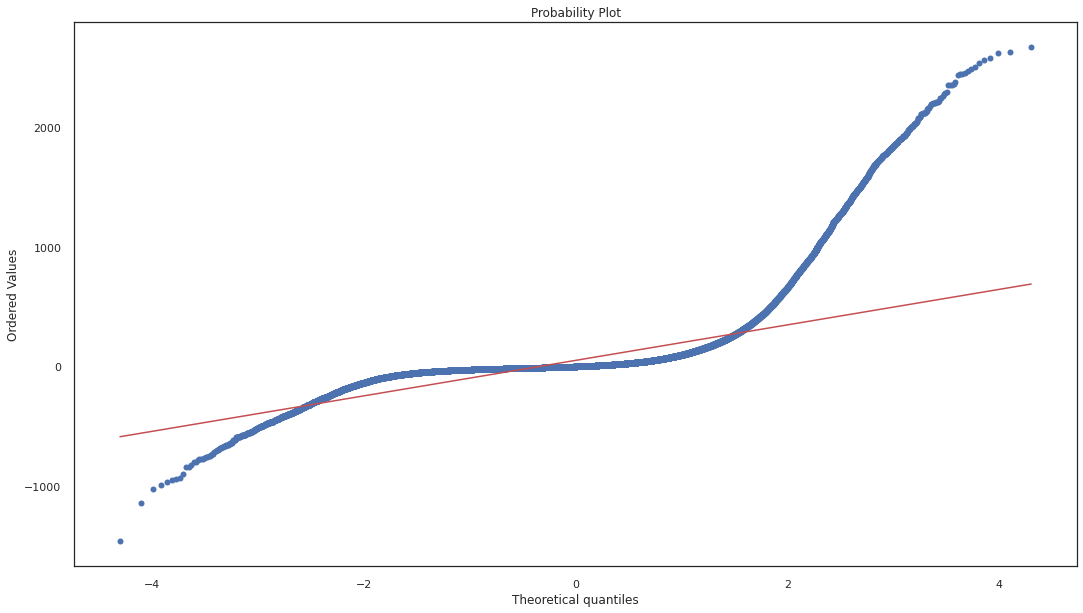

In [66]:
from scipy.stats import norm

sns.set(rc={'figure.figsize':(16,10)})
sns.set_style("white")

sns.distplot(ads['TTR_ERROR'],fit=norm);
fig = plt.figure()
print('\n')
print('\n')
res = stats.probplot(ads['TTR_ERROR'], plot=plt)